# Evaluating DeepLiftSHAP

## Imports and Setup

In [1]:
import os
import platform
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

PosixPath('/home2/jgcw74/l3_project')

In [2]:
import helpers
import dataset_processing.eurosat

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from captum.attr import DeepLiftShap
import shap

import numpy as np
import matplotlib.pyplot as plt
import einops
from tqdm.autonotebook import tqdm

import torch
import torchvision.transforms.v2 as transforms
from safetensors.torch import load_model

In [4]:
print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe to use as a cuda device.
Using cuda as torch device.


In [5]:
np_rng = np.random.default_rng(42)
_ = torch.manual_seed(42)

# EuroSAT (RGB) Dataset

In [6]:
base_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),  # scaling handles by normalise below
    dataset_processing.core.RSNormaliseTransform(0, 2750),
    # normalise to [0, 1] (based on maximums used in original paper)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),  # shift to mean 0 and std 1

    # scale as expected by ResNet (see https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights)
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
])
wrapped_base_transforms = dataset_processing.core.tensor_dict_transform_wrapper(base_transforms)

eurosat_val_ds = dataset_processing.eurosat.get_dataset(
    "val", bands=("B04", "B03", "B02"),  # RGB bands
    transforms=wrapped_base_transforms, download=False
)

print(f"There are {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_val_ds[0]["image"].size(), eurosat_val_ds[0]["label"])

There are 5400 validation samples.
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)


In [7]:
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

In [8]:
def show_image(img: torch.Tensor):
    if img.min() < 0:
        img = (img + 1) / 2  # un-normalise
    img = np.transpose(img.cpu(), (1, 2, 0))  # move colour channel to end
    plt.imshow(img)
    plt.axis("off")

## ResNet 50

### Load Model

In [9]:
checkpoints_path = Path.cwd() / 'checkpoints'
assert checkpoints_path.exists()

In [10]:
all_resnet50_saved = list(checkpoints_path.glob('./resnet50/*.st'))
# print(all_resnet50_saved)
latest_resnet50_path = max(all_resnet50_saved, key=os.path.getctime)
latest_resnet50_path

PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_ft_weights(0.989).st')

In [11]:
resnet50 = helpers.models.FineTunedResNet50(num_classes=len(eurosat_val_ds.classes)).to(device)

In [12]:
print('Missing/Unexpected keys:', load_model(resnet50, latest_resnet50_path))

Missing/Unexpected keys: (set(), [])


#### Confirm model accuracy

In [13]:
_, acc = helpers.ml.validation_step(
    resnet50, torch.nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
)
print("Validation accuracy", acc)

Validating:   0%|          | 0/169 [00:00<?, ?it/s]

Validation accuracy 0.9892751479289941


### Select images to explain

In [14]:
idxs_to_explain = np_rng.integers(0, len(eurosat_val_ds), 5)
imgs_to_explain = torch.stack([eurosat_val_ds[i]["image"] for i in idxs_to_explain]).to(device)
true_labels = [eurosat_val_ds[i]["label"] for i in idxs_to_explain]

blurred_imgs = transforms.functional.gaussian_blur_image(imgs_to_explain, kernel_size=21, sigma=10)
black_imgs = torch.zeros_like(imgs_to_explain) - 1
# Black background as in https://dl.acm.org/doi/abs/10.1145/3331184.3331312
# Blurred as in https://www.sciencedirect.com/science/article/pii/S0303243421002270

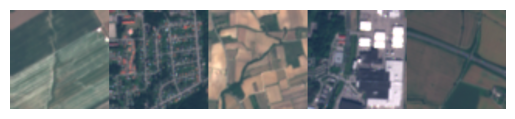

In [15]:
show_image(einops.rearrange(imgs_to_explain, "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

[tensor(0), tensor(7), tensor(6), tensor(4), tensor(3)]


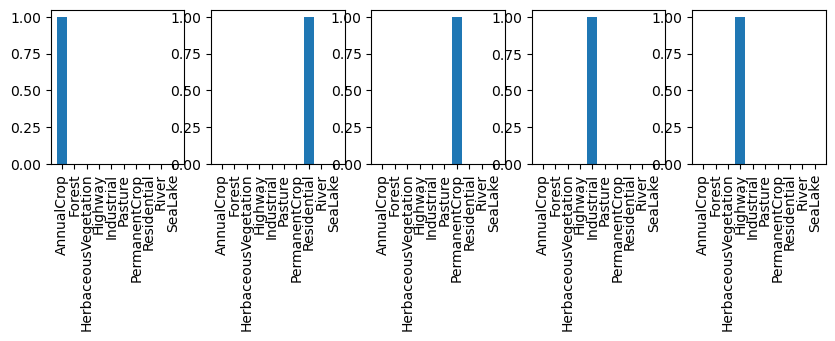

In [16]:
preds = resnet50(imgs_to_explain)
preds = torch.softmax(preds, dim=-1).cpu().detach().numpy()
_, axs = plt.subplots(1, len(idxs_to_explain), figsize=(2 * len(idxs_to_explain), 2))
for i in range(len(idxs_to_explain)):
    ax: plt.Axes = axs[i]
    ax.bar(eurosat_val_ds.classes, preds[i])
    # rotate x ticks for axis
    ax.tick_params(axis='x', rotation=90)
print(true_labels)

In [17]:
random_blurred_bg_imgs = transforms.functional.gaussian_blur_image(
    torch.stack([eurosat_val_ds[i]["image"] for i in np_rng.integers(0, len(eurosat_val_ds), 100)]),
    kernel_size=15, sigma=10
).to(device)

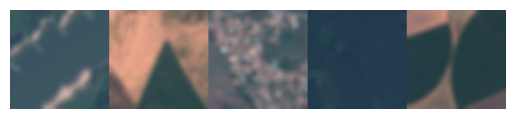

In [72]:
show_image(einops.rearrange(random_blurred_bg_imgs[:5], "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

### Run SHAP

#### Captum DeepLiftShap

In [14]:
deep_shap_explainer = DeepLiftShap(resnet50, multiply_by_inputs=True)  # True for global attribution

In [109]:
shap_vals = torch.zeros(0).to(device)
for i in tqdm(range(len(eurosat_val_ds.classes))):
    shap_values_for_ith_label = deep_shap_explainer.attribute(
        imgs_to_explain, blurred_imgs,
        # blurred_background_imgs[:10],
        target=torch.tensor(i).to(device)
    ).detach()
    shap_vals = torch.cat(
        (shap_vals, shap_values_for_ith_label.unsqueeze(0)),
        dim=0
    ) if shap_vals.size else shap_values_for_ith_label.unsqueeze(0)
shap_vals.size()

  0%|          | 0/10 [00:00<?, ?it/s]

/home2/jgcw74/miniconda3/envs/sat_project/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


torch.Size([10, 5, 3, 224, 224])

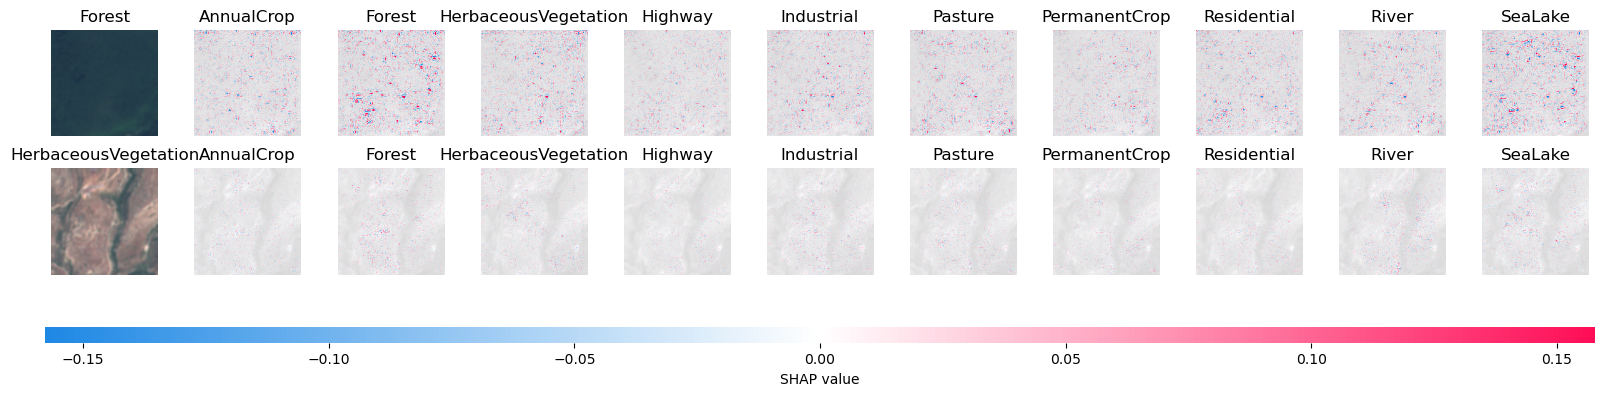

In [125]:
n = 2
shap.image_plot(
    list(einops.rearrange(shap_vals[:, :n], "l b c h w -> l b h w c").cpu().numpy()),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
    hspace=0.3,
)

##### Pooled SHAP values

In [122]:
pool_size = 16
pooled_shap_vals = (pool_size ** 2) * torch.nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    shap_vals.flatten(0, 1)).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size, dim=-1)
pooled_shap_vals = torch.unflatten(pooled_shap_vals, 0, (len(eurosat_val_ds.classes), -1))

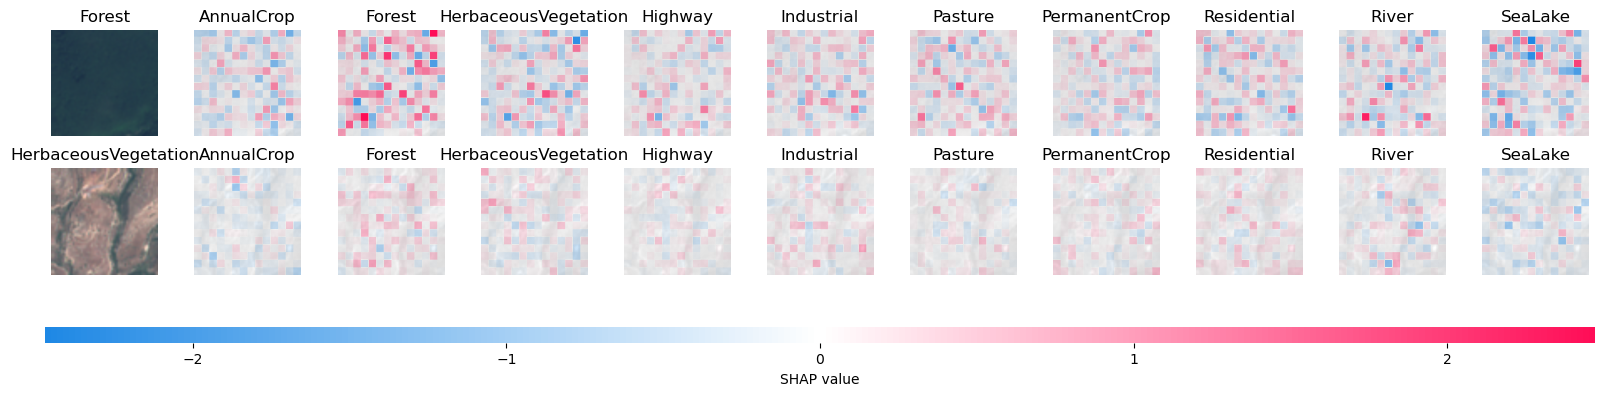

In [123]:
n = 2
shap.image_plot(
    list(einops.rearrange(pooled_shap_vals[:, :n], "l b c h w -> l b h w c").cpu().numpy()),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

#### Original SHAP library

In [144]:
def predict_fn(np_imgs: np.ndarray):
    model_input_img = einops.rearrange(torch.Tensor(np_imgs * 2) - 1, "b h w c -> b c h w").to(device)
    model_output = resnet50(model_input_img)
    # softmax_output = torch.softmax(model_output, dim=-1)
    return model_output.cpu().detach().numpy()

In [155]:
np_01_imgs_to_explain = einops.rearrange((imgs_to_explain + 1) / 2, "b c h w -> b h w c").cpu().numpy()

##### Partition Explainer

Following regime in https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

In [148]:
blur_masker = shap.maskers.Image("blur(128,128)", np_01_imgs_to_explain[0].shape)
explainer = shap.PartitionExplainer(predict_fn, blur_masker, output_names=eurosat_val_ds.classes)

In [149]:
shap_values = explainer(
    np_01_imgs_to_explain,
    max_evals=10000,
    batch_size=32,
    outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:47<00:53, 26.96s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [02:40<00:37, 37.77s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [03:34<00:00, 43.99s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [04:29, 53.90s/it]                       


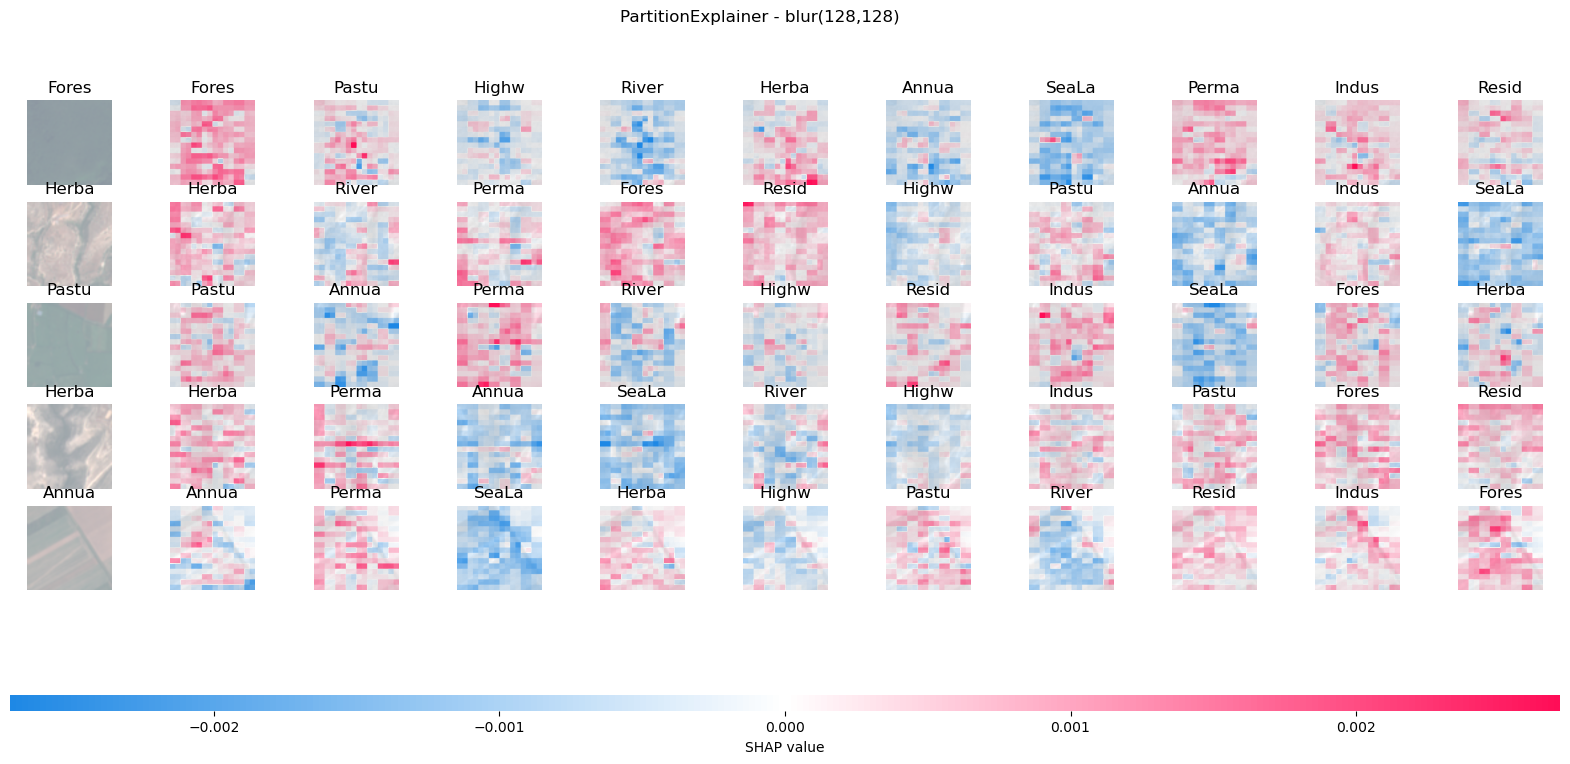

In [150]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(shap_values.values, -1, 0)],
    pixel_values=((shap_values.data + 1) / 2),
    labels=np.vectorize(lambda x: x[:5])(shap_values.output_names),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    show=False,
)
_ = plt.gcf().suptitle(f"{explainer.__class__.__name__} - {blur_masker.mask_value}")

###### Using 0 masker

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [01:30, 45.38s/it]               


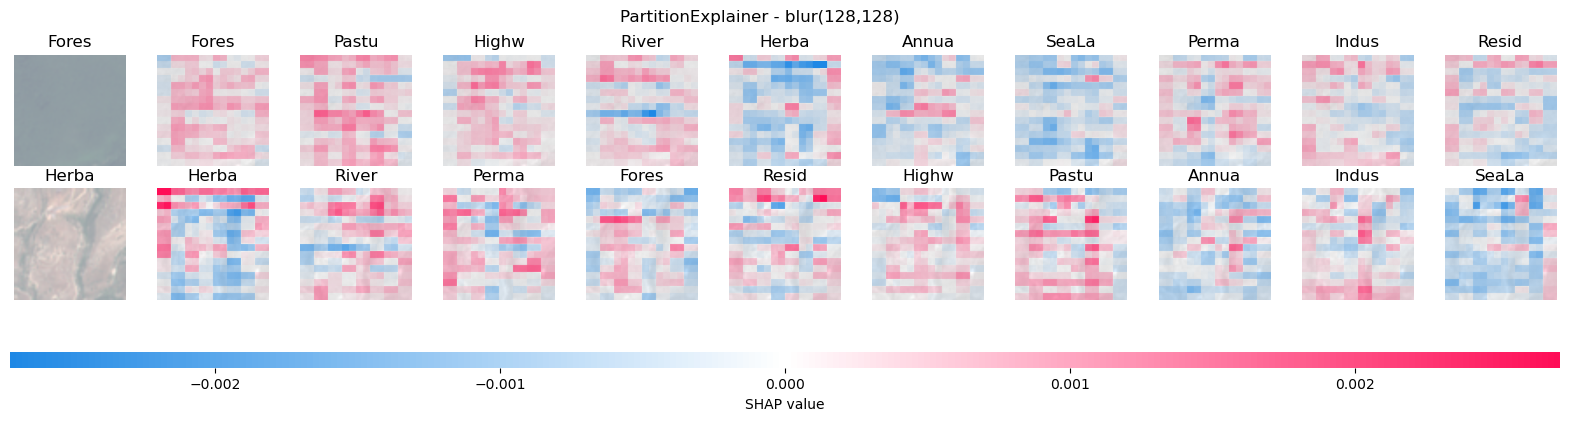

In [158]:
masker = shap.maskers.Image(0, np_01_imgs_to_explain[0].shape)  # fill with zeros rather than blurring
explainer = shap.PartitionExplainer(predict_fn, masker, output_names=eurosat_val_ds.classes)
shap_values = explainer(
    np_01_imgs_to_explain[:2],
    max_evals=10000,
    batch_size=32,
    outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)
shap.image_plot(
    shap_values=[val for val in np.moveaxis(shap_values.values, -1, 0)],
    pixel_values=((shap_values.data + 1) / 2),
    labels=np.vectorize(lambda x: x[:5])(shap_values.output_names),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=False,
)
_ = plt.gcf().suptitle(f"{explainer.__class__.__name__} - {blur_masker.mask_value}")

##### Deep Explainer

Following regime in https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

In [18]:
random_bg_imgs = torch.stack([eurosat_val_ds[i]["image"] for i in np_rng.integers(0, len(eurosat_val_ds), 100)]).to(
    device)

In [23]:
class ResNet50Wrapper(torch.nn.Module):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return torch.softmax(self.model(x), dim=-1)

In [73]:
# wrapped_resnet50 = ResNet50Wrapper(resnet50)
deep_explainer = shap.DeepExplainer(resnet50, random_bg_imgs[:50])

Requires a lot of GPU memory - 50 background images requires 17.3GB of GPU memory/VRAM

In [74]:
shap_values = deep_explainer.shap_values(imgs_to_explain[:2], check_additivity=False)
shap_values = einops.rearrange(shap_values, "b c h w l -> l b c h w")

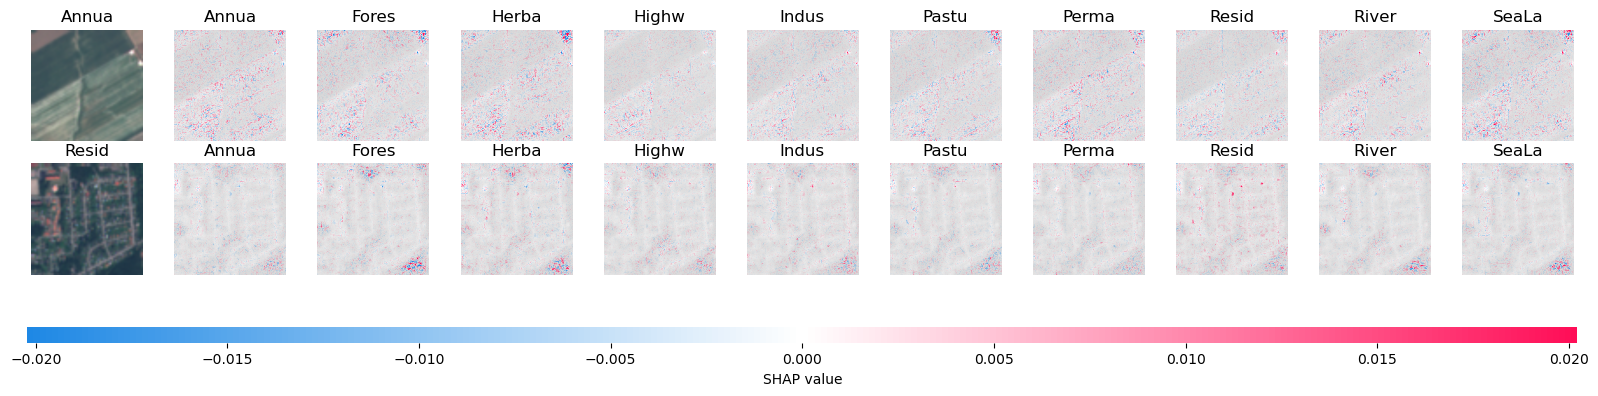

In [75]:
shap.image_plot(
    list(einops.rearrange(shap_values, "l b c h w -> l b h w c")),
    pixel_values=einops.rearrange((imgs_to_explain[:2] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=(np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain[:2].shape[0], 1))),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=True,
)

In [76]:
pool_size = 16
pooled_shap_vals = (pool_size ** 2) * torch.nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    torch.from_numpy(shap_values).flatten(0, 1)).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size,
                                                                                                        dim=-1)
pooled_shap_vals = torch.unflatten(pooled_shap_vals, 0, (len(eurosat_val_ds.classes), -1))

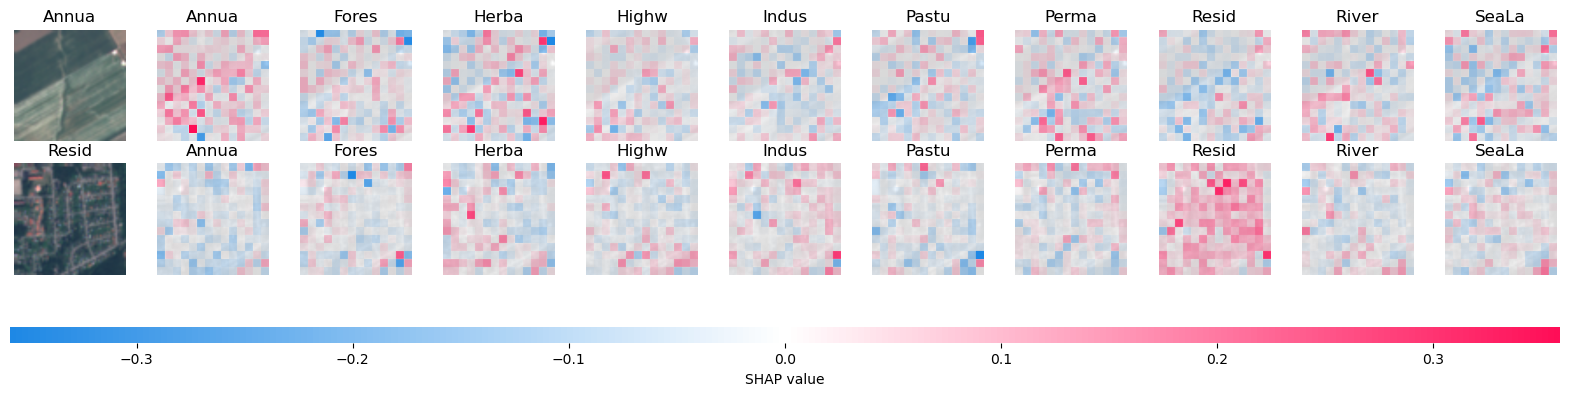

In [77]:
shap.image_plot(
    list(einops.rearrange(pooled_shap_vals, "l b c h w -> l b h w c")),
    pixel_values=einops.rearrange((imgs_to_explain[:2] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=(np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain[:2].shape[0], 1))),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=True,
)